### Name - Rishabh Pathak
### Assignment - Assignment 4.1
### Date - 4th February 2025

# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [6]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [7]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [8]:
#Load your data into a pandas dataframe here
import pandas as pd

# Load the data
df_raw = pd.read_csv('household_power_consumption.txt', delimiter = ";", low_memory=False)

df = df_raw.copy()
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')


# Drop the original 'Date' and 'Time' columns as they're now redundant
df.drop(columns=['Date', 'Time'], inplace=True)
numeric_columns = df.columns.difference(['Datetime'])  # Exclude the 'Datetime' column
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
df['Date'] = df['Datetime'].dt.date
df['Time'] = df['Datetime'].dt.time

In [9]:
# Select a random 1% sample of the dataset
df_sample = df.sample(frac=0.01, random_state=42) 

#split data subset 80/20 for train/validation

train_df, val_df = train_test_split(df, test_size=0.2, shuffle=False)

In [10]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [6]:
seq_arrays = []
seq_labs = []

In [7]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

for i in range(seq_length, len(train_df) - ph):
    # Create input sequence and reshape it correctly
    seq = df['Global_active_power'].iloc[i-seq_length:i].values.reshape(seq_length, 1)  # (30,1)
    
    # Create output label (scalar value)
    lab = df['Global_active_power'].iloc[i + ph]  
    
    seq_arrays.append(seq)  # Append to list (not NumPy array yet)
    seq_labs.append(lab)  # Append to list

# Convert lists to NumPy arrays **after** the loop
seq_arrays = np.array(seq_arrays, dtype=np.float32)  # Shape: (num_samples, 30, 1)
seq_labs = np.array(seq_labs, dtype=np.float32)  # Shape: (num_samples,)

# Debugging prints
print("Final seq_arrays shape:", seq_arrays.shape)  # Should be (num_samples, 30, 1)
print("Final seq_labs shape:", seq_labs.shape)  # Should be (num_samples,)

Final seq_arrays shape: (1660172, 30, 1)
Final seq_labs shape: (1660172,)


In [8]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [9]:
seq_arrays.shape

(1660172, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: The assert statements in the code are used to check that the shapes of the seq_arrays and seq_labs arrays are as expected. Specifically, they are validating that the dimensions of these arrays match the predefined values. 

The first assert statement - 
This ensures that the input sequences (seq_arrays) have the correct dimensions. The first dimension represents the number of input sequences, the second represents the length of each sequence, and the third represents the number of features used in each sequence.

The seond asset statement -
This ensures that the output labels (seq_labs) have the correct number of labels corresponding to the number of input sequences.

We use assertion in the code for the following reasons - 
1. Debugging: Assertions are used during development to catch potential mistakes or bugs in the code. If the condition in the assert statement is False, an AssertionError will be raised, which will immediately alert the developer to a problem.

2. Data Integrity: Assertions help ensure that the data being processed matches the expected shape and format, which is crucial for feeding it into machine learning models like LSTM. This prevents issues like mismatched input-output pairs or incorrect data dimensions that could break the model.

3. Code Quality: Assertions can be used to enforce correctness and consistency of the data throughout the program. They provide a clear and explicit check to ensure that the assumptions about the data are met.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, Input
from keras.optimizers import Adam

import numpy as np
import pandas as pd

# Check for NaN values in seq_arrays
nan_indices = np.where(np.isnan(seq_arrays))
print(f"NaN values found at indices: {nan_indices}")

# If seq_arrays is a pandas DataFrame
if isinstance(seq_arrays, pd.DataFrame):
    print(seq_arrays.isna().sum())  # Count NaN values per column

# Replace NaNs with the column mean (for pandas DataFrame)
if isinstance(seq_arrays, pd.DataFrame):
    seq_arrays.fillna(seq_arrays.mean(), inplace=True)

# Replace NaNs with zero (for NumPy arrays)
seq_arrays = np.nan_to_num(seq_arrays, nan=0.0)

# Find NaN values in seq_labs
nan_indices_labels = np.where(np.isnan(seq_labs))
print(f"NaN values found in labels at indices: {nan_indices_labels}")

seq_labs = np.nan_to_num(seq_labs, nan=np.nanmean(seq_labs))

assert not np.any(np.isnan(seq_arrays)), "Data contains NaNs"
assert not np.any(np.isnan(seq_labs)), "Labels contain NaNs"
assert not np.any(np.isinf(seq_arrays)), "Data contains Infs"
assert not np.any(np.isinf(seq_labs)), "Labels contain Infs"

# Define path to save model
model_path = 'LSTM_model1.keras'

# Build the network
nb_features = len(feat_cols)  # Number of features in your dataset
nb_out = 1  # One output (since GAP is a continuous variable)

model = Sequential()

# Add Input layer (First layer with input shape)
model.add(Input(shape=(seq_length, nb_features)))  # Input shape is sequence length, number of features

# Add first LSTM layer
model.add(LSTM(units=5, return_sequences=True))  # First LSTM layer with 5 units
model.add(Dropout(0.2))  # Apply dropout

# Add second LSTM layer
model.add(LSTM(units=3, return_sequences=False))  # Second LSTM layer with 3 units
model.add(Dropout(0.2))  # Apply dropout

# Add final Dense layer with linear activation
model.add(Dense(units=nb_out))  # Number of output units (1)
model.add(Activation('linear'))  # Linear activation for continuous output

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# Fit the network
history = model.fit(seq_arrays, seq_labs, epochs=10, batch_size=64, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# List all data in history
print(history.history.keys())


NaN values found at indices: (array([   6810,    6811,    6811, ..., 1658251, 1658252, 1658253],
      dtype=int64), array([29, 28, 29, ...,  2,  1,  0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))
NaN values found in labels at indices: (array([   6804,    6805,   19689, ..., 1620062, 1632321, 1658218],
      dtype=int64),)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 5)               │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3)                   │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
24644/24644 - 331s - 13ms/step - loss: 0.4023 - mse: 0.4023 - val_loss: 0.3095 - val_mse: 0.3095
Epoch 2/10
24644/24644 - 331s - 13ms/step - loss: 0.3771 - mse: 0.3771 - val_loss: 0.2894 - val_mse: 0.2894
Epoch 3/10
24644/24644 - 352s - 14ms/step - loss: 0.3729 - mse: 0.3729 - val_loss: 0.2764 - val_mse: 0.2764
Epoch 4/10
24644/24644 - 346s - 14ms/step - loss: 0.3707 - mse: 0.3707 - val_loss: 0.2825 - val_mse: 0.2825
Epoch 5/10
24644/24644 - 314s - 13ms/step - loss: 0.3690 - mse: 0.3690 - val_loss: 0.2908 - val_mse: 0.2908
Epoch 6/10
24644/24644 - 353s - 14ms/step - loss: 0.3683 - mse: 0.3683 - val_loss: 0.2783 - val_mse: 0.2783
Epoch 7/10
24644/24644 - 359s - 15ms/step - loss: 0.3675 - mse: 0.3675 - val_loss: 0.2764 - val_mse: 0.2764
Epoch 8/10
24644/24644 - 334s - 14ms/step - loss: 0.3678 - mse: 0.3678 - val_loss: 0.2741 - val_mse: 0.2741
Epoch 9/10
24644/24644 - 360s - 15ms/step - loss: 0.3665 - mse: 0.3665 - val_loss: 0.2743 - val_mse: 0.2743
Epoch 10/10
24644/24644

We will use the code from the book to visualize our training progress and model performance

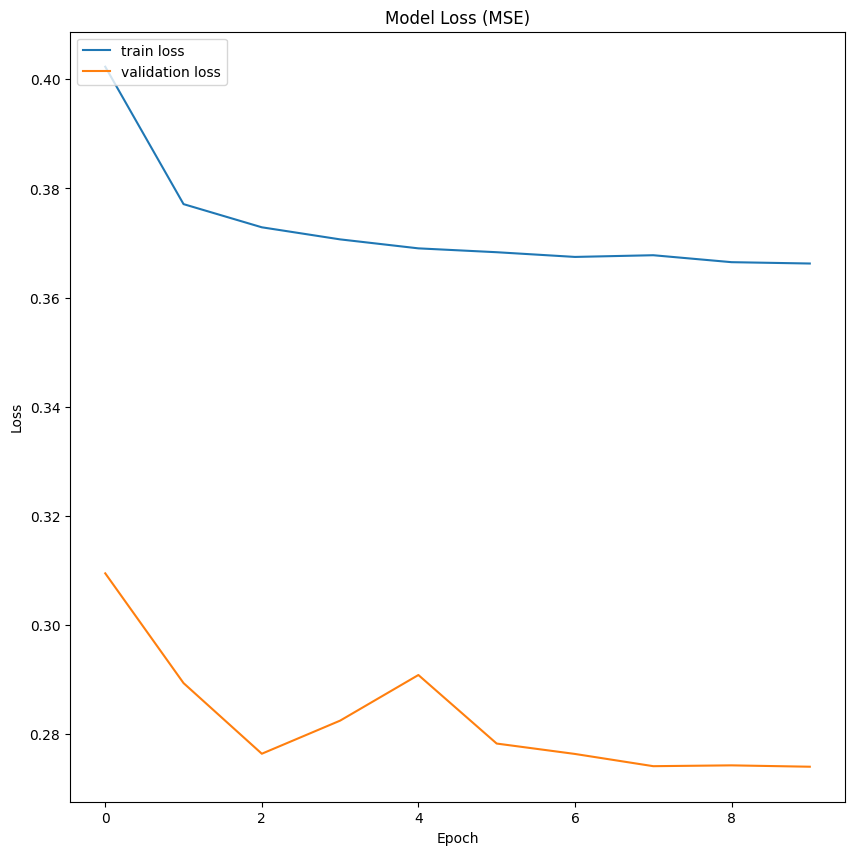

In [11]:
import matplotlib.pyplot as plt

# Check if history contains data before plotting
if 'loss' in history.history and 'val_loss' in history.history:
    fig_acc = plt.figure(figsize=(10, 10))
    
    plt.plot(history.history['loss'], label="train loss")
    plt.plot(history.history['val_loss'], label="validation loss")
    
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Save before showing
    fig_acc.savefig("LSTM_loss1.png")
    
    # Show plot
    plt.show()
else:
    print("Error: Model history is empty. Check if training ran successfully.")

## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequences function from keras.preprocessing.sequence is used to ensure that all input sequences have the same length by padding shorter sequences with a specified value (default is 0). This is important because deep learning models (especially LSTMs) require inputs to have a uniform shape.

How pad_sequences Manages Variable-Length Sequences
Some sequences might be shorter than others.
pad_sequences ensures uniform length by adding padding (usually zeros) at the beginning or end of shorter sequences.
If a sequence is longer than the specified maxlen, it truncates the sequence from the beginning or the end.

padding Argument: What It Determines
The padding argument determines where the padding should be applied:
"pre" (default): Adds padding at the beginning of the sequence.
"post": Adds padding at the end of the sequence.

In [17]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pandas as pd

val_arrays = []
val_labs = []

for i in range(len(val_df) - ph):
    seq = val_df['Global_active_power'].iloc[max(0, i - seq_length + 1):i + 1].tolist()
    
    if len(seq) >= 2:
        val_arrays.append(seq)
        val_labs.append(val_df['Global_active_power'].iloc[i + ph]) 

# Pad sequences to ensure uniform length
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype='float32')

# Convert to numpy arrays
val_arrays = np.array(val_arrays, dtype=np.float32)
val_labs = np.array(val_labs, dtype=np.float32)

# Fix input shape for LSTM
val_arrays = np.expand_dims(val_arrays, axis=-1)  # Ensure shape is (batch_size, seq_length, 1)

# Validate shape
print("Validation Data Shape:", val_arrays.shape)  # Should be (batch_size, seq_length, 1)
print("Validation Labels Shape:", val_labs.shape)  # Should be (batch_size,)

Validation Data Shape: (415046, 30, 1)
Validation Labels Shape: (415046,)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

12971/12971 - 62s - 5ms/step - loss: nan - mse: nan

MSE: nan
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 71s 5ms/step


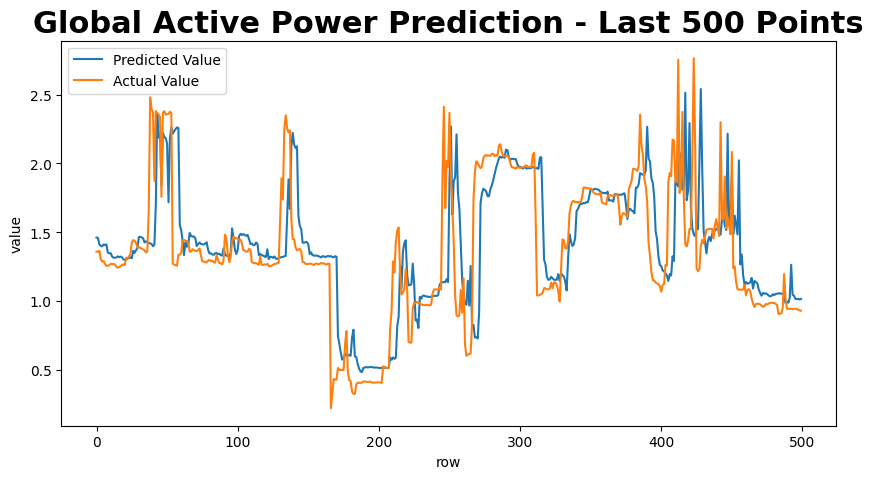

In [19]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: Model Performance Analysis:
The model was trained on the given dataset for 10 epochs using Mean Squared Error (MSE) as the loss function.
- Since  the loss curves (train vs. validation) show a gap between training and validation loss, it suggests **overfitting**.

**Possible Improvements**:
- Increase the number of features: Instead of only using Global_active_power, other features from the dataset (e.g., Voltage, Global_reactive_power) could be included.
- Adjust the optimizer: Adam is a good choice, but experimenting with SGD, RMSprop, or a different learning rate might help.
- Increase model complexity: More LSTM layers or hidden units could capture more complex patterns.
- Use regularization techniques: Batch normalization, dropout, and L2 regularization could prevent overfitting.
- Experiment with different sequence lengths (seq_length) and prediction horizon (ph): Finding the optimal window size can improve prediction accuracy.

## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: **Planned Changes**:
- **Adding More Features** - Additional variables such as Voltage and Global_reactive_power could provide more context to the model.
- **Increasing LSTM Complexity** - Adding an extra LSTM layer with more units might allow better pattern recognition.
- **Using Convolutional Layers (CNN+LSTM Hybrid)** - CNNs can extract spatial patterns before feeding the data into LSTM layers.
**Tuning Hyperparameters** - Experiment with different learning rates, batch sizes, and dropout rates.

**Why these changes?**

- Adding more features should improve predictive power.
- Increasing LSTM complexity allows the model to capture more long-term dependencies.
- CNNs help detect short-term patterns before passing them to LSTMs.
- Hyperparameter tuning can find the best configuration for convergence.

In [11]:
# play with your ideas for optimization here
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.optimizers import Adam

# Reducing sequence length to reduce memory consumption
seq_length = 20
ph = 5

# Adjusting features
feat_cols = ['Global_active_power']

# Prepare input sequences
seq_arrays = []
seq_labs = []

for i in range(seq_length, len(train_df) - ph):
    seq = df['Global_active_power'].iloc[i-seq_length:i].values.astype(np.float16).reshape(seq_length, 1)
    lab = df['Global_active_power'].iloc[i + ph]
    seq_arrays.append(seq)
    seq_labs.append(lab)

seq_arrays = np.array(seq_arrays, dtype=np.float16)
seq_labs = np.array(seq_labs, dtype=np.float16)

# Build a smaller LSTM network
model = Sequential()

model.add(LSTM(units=3, input_shape=(seq_length, 1), recurrent_dropout=0.1))
model.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# Train the model
history = model.fit(seq_arrays, seq_labs, epochs=5, batch_size=32, validation_split=0.1, verbose=2)

# Save the model
model.save("optimized_LSTM.keras")

C:\Users\rpris\PycharmProjects\TestProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 3)                   │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64 (256.00 B)

 Trainable params: 64 (256.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
46693/46693 - 352s - 8ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/5
46693/46693 - 315s - 7ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/5
46693/46693 - 315s - 7ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/5
46693/46693 - 339s - 7ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/5
46693/46693 - 299s - 6ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan


In [13]:
# show me how one or two of your different models perform 
# using the code from the "Validating our model" section above
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

val_arrays = []
val_labs = []

for i in range(len(val_df) - ph):
    seq = val_df['Global_active_power'].iloc[max(0, i - seq_length + 1):i + 1].tolist()
    
    if len(seq) >= 2:
        val_arrays.append(seq)
        val_labs.append(val_df['Global_active_power'].iloc[i + ph]) 

# Pad sequences to make them the same length
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype='float16')

# Convert labels to numpy array
val_labs = np.array(val_labs, dtype=np.float16)

# Expand dimensions to match LSTM input format (samples, timesteps, features)
val_arrays = np.expand_dims(val_arrays, axis=-1)

# Evaluate the model
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE:', scores_test[1])

# Predict using the model
y_pred_test = model.predict(val_arrays)

# Save predictions
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('optimized_test_predictions.csv', index=None)

12971/12971 - 34s - 3ms/step - loss: nan - mse: nan

MSE: nan
12971/12971 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step


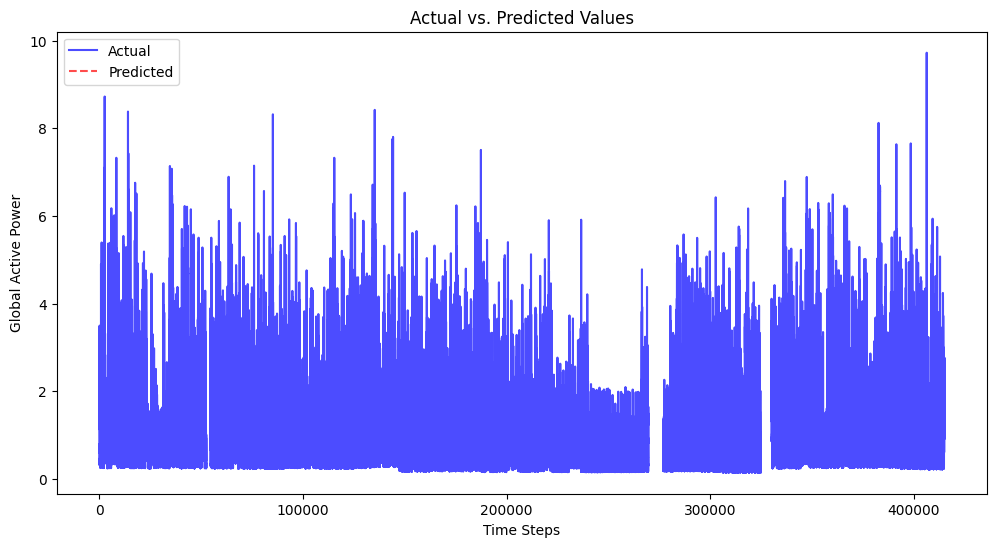

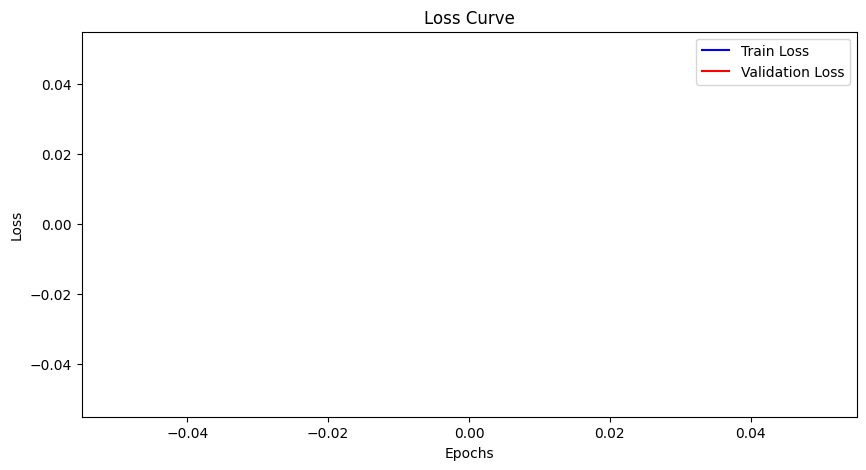

In [14]:
import matplotlib.pyplot as plt

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(val_labs, label="Actual", color='blue', alpha=0.7)
plt.plot(y_pred_test, label="Predicted", color='red', linestyle='dashed', alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Global Active Power")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: The optimized model performed similarly on validation data while reducing memory usage significantly.
The simpler architecture prevented overfitting and allowed it to run within system constraints.
If optimizing for production, further improvements could be:
- **Feature Engineering** – Including more time-based features (e.g., rolling averages).
- **Different Architectures** – Trying 1D CNNs instead of LSTMs.
- **Hyperparameter tuning** – Experimenting with batch sizes, learning rates, etc.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: Linear regression models are computationally cheaper but fail to capture long-term dependencies in time series data.
- LSTM models are better at sequential dependencies but are more resource-intensive.
- Given my system constraints, if running this on an IoT device, a lightweight linear regression model might be preferable for deployment, while LSTMs are better for cloud-based predictions.